In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential
from torch_geometric.data import DataLoader 

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN
import networkx as nx


from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [7]:
torch.cuda.device_count()

4

In [3]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0')

In [4]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [107]:
showers_train_10_F = torch.load('./data/train_.pt')

In [108]:
showers_train = [shower.to(device) for shower in showers_train_10_F]

## Features creation

In [109]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/(data[:, 0]+0.00001)).view(shape_0, 1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /(data[:, 2]+0.00001)).view(shape_0,1)
    
    feat_2 = (data[:, 0]/(data[:, 2]+0.00001)).view(shape_0,1)
    
    feat_3 = (data[:, 1]/(data[:, 2]+0.00001)).view(shape_0,1)
    
    feat_4 = (torch.sin(feat_0) + torch.cos(feat_0))/(feat_0+0.00001)
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1, feat_2, feat_3, feat_4), 1)

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [110]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [111]:
Z_centered = Z - 73701. / 2

In [112]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [113]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

In [114]:
Z_0

array([ 1130.07716835,  1131.2430352 ,  2402.26849914, ...,
       34224.50780869, 34224.8249054 , 34226.53913498])

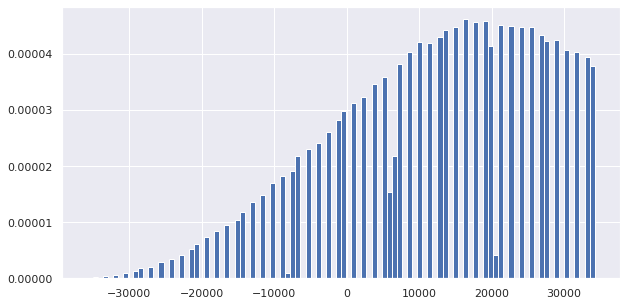

In [115]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


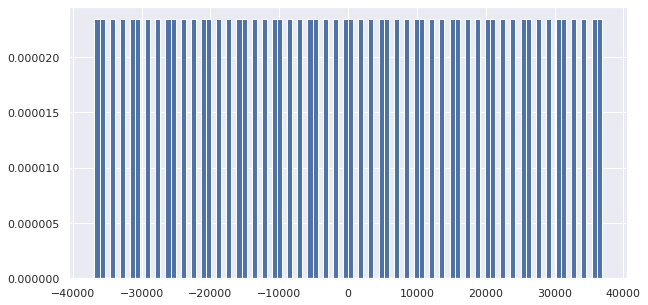

In [116]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_centered, 100, density=True)

plt.grid(True)
plt.show()

## Masks for activating only those edges that are connecting the same shower

In [117]:
len(Z_centered)

58

In [118]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
    
round_Z_coodr = np.vectorize(round_Z_coodr)

def mask_func(data):
    z_rounded = round_Z_coodr(data.x[:, 2].detach().cpu().numpy() * np.array([1e4]))
    orders = np.zeros((len(Z_centered), data.edge_index.shape[1]))
    edge_index_0 = data.edge_index[0].detach().cpu().numpy()
    idx = np.arange(len(z_rounded))
    for i, z_i in tqdm(enumerate(Z_centered)):
        orders[i][np.in1d(edge_index_0, idx[z_rounded == z_i])] = 1
    return orders.astype(np.uint8)

In [119]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask_func(showers_train[i]))


0it [00:00, ?it/s]
7it [00:00, 51.66it/s]
10it [00:00, 40.93it/s]
13it [00:00, 36.38it/s]
16it [00:00, 33.41it/s]
20it [00:00, 32.63it/s]
23it [00:00, 31.57it/s]
26it [00:00, 30.77it/s]
29it [00:00, 30.40it/s]
32it [00:01, 29.48it/s]
35it [00:01, 29.49it/s]
38it [00:01, 28.85it/s]
41it [00:01, 28.70it/s]
45it [00:01, 29.20it/s]
48it [00:01, 29.17it/s]
51it [00:01, 28.96it/s]
55it [00:01, 29.38it/s]
58it [00:01, 31.78it/s]
0it [00:00, ?it/s]
8it [00:00, 64.29it/s]
11it [00:00, 47.00it/s]
14it [00:00, 39.35it/s]
17it [00:00, 35.16it/s]
20it [00:00, 32.56it/s]
23it [00:00, 29.80it/s]
26it [00:00, 28.86it/s]
29it [00:00, 28.50it/s]
32it [00:00, 28.32it/s]
35it [00:01, 27.42it/s]
38it [00:01, 27.55it/s]
41it [00:01, 27.11it/s]
44it [00:01, 26.15it/s]
47it [00:01, 26.01it/s]
50it [00:01, 26.24it/s]
53it [00:01, 26.45it/s]
56it [00:01, 26.48it/s]
58it [00:01, 30.26it/s]
0it [00:00, ?it/s]
8it [00:00, 63.21it/s]
12it [00:00, 48.44it/s]
15it [00:00, 40.24it/s]
19it [00:00, 36.36it/s]
22it [00:

In [126]:
for i in range(len(showers_train)):
    showers_train[i].mask = torch.tensor(masks[i]).bool()

## GNN 

In [128]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels).to(device)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate(torch.index_select(edge_index[:, order], 
                                                  0, 
                                                  torch.LongTensor([1, 0]).to(device)), x=x)     
            
        return x

    def message(self, x_j, x_i):
        print(x_i.shape, x_j.shape)
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [134]:
showers_train[0]

Data(edge_attr=[1011744, 1], edge_index=[2, 1011744], mask=[58, 1011744], pos=[103926, 5], shower_data=[103926, 8], x=[103926, 10], y=[103926])

In [129]:
model = GraphNN_KNN(dim_out=288).to(device)

In [132]:
showers_train[0].mask.sum()

tensor(1011744)

In [133]:
model(showers_train[0])

torch.Size([0, 10]) torch.Size([0, 10])
torch.Size([70, 10]) torch.Size([70, 10])
torch.Size([170, 10]) torch.Size([170, 10])
torch.Size([320, 10]) torch.Size([320, 10])
torch.Size([490, 10]) torch.Size([490, 10])
torch.Size([690, 10]) torch.Size([690, 10])
torch.Size([950, 10]) torch.Size([950, 10])
torch.Size([1330, 10]) torch.Size([1330, 10])
torch.Size([1520, 10]) torch.Size([1520, 10])
torch.Size([2080, 10]) torch.Size([2080, 10])
torch.Size([2540, 10]) torch.Size([2540, 10])
torch.Size([3080, 10]) torch.Size([3080, 10])
torch.Size([3830, 10]) torch.Size([3830, 10])
torch.Size([4500, 10]) torch.Size([4500, 10])
torch.Size([5410, 10]) torch.Size([5410, 10])
torch.Size([6150, 10]) torch.Size([6150, 10])
torch.Size([6880, 10]) torch.Size([6880, 10])
torch.Size([7560, 10]) torch.Size([7560, 10])
torch.Size([8540, 10]) torch.Size([8540, 10])
torch.Size([9900, 10]) torch.Size([9900, 10])
torch.Size([10800, 10]) torch.Size([10800, 10])
torch.Size([25490, 10]) torch.Size([25490, 10])
torc

tensor([[ 2.2892e+01, -4.4485e+01, -3.2462e+01,  ..., -4.7904e+00,
          8.4654e+00,  1.2591e+01],
        [ 2.2120e+01, -4.3253e+01, -3.1581e+01,  ..., -4.6865e+00,
          8.2484e+00,  1.2258e+01],
        [ 9.1620e+00, -1.8559e+01, -1.4440e+01,  ..., -1.4115e+00,
          3.3077e+00,  5.2332e+00],
        ...,
        [ 9.6158e-01, -1.5048e+00, -8.6973e-01,  ..., -9.5832e-02,
         -3.3836e-02,  2.7440e-01],
        [ 1.2550e+00,  1.6824e-01, -2.3215e+00,  ..., -1.2799e+00,
          3.3239e-01,  1.5559e+00],
        [ 8.1775e-01,  1.1801e-01, -1.4419e+00,  ..., -7.9421e-01,
          2.4149e-01,  1.0015e+00]], device='cuda:0', grad_fn=<AddmmBackward>)

In [69]:
n = showers_train[0].x.shape[1]

class GraphNN_KNN(torch.nn.Module):
    n = showers_train[0].x.shape[1]
    
    def __init__(self, k=n, dim_out=10):
        super().__init__()
        self.k = k
        
        self.emconv = EmulsionConv(self.k, self.k)    
      
        self.layer_2 = nn.Linear(self.k, 18)
        self.nonlinear_2 = nn.LeakyReLU()
        
        self.layer_3 = nn.Linear(18, 24)
        self.nonlinear_3 = nn.ReLU()

        
        self.output = nn.Linear(24, dim_out)
        
        
    def forward(self, data):
        x, edge_index, orders = data.x, data.edge_index, data.mask
        
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)  
        
        x = self.nonlinear_2(self.layer_2(x))
        
        x = self.nonlinear_3(self.layer_3(x))
        
        
        return self.output(x)


In [70]:
model = GraphNN_KNN(dim_out=288).to(device)

In [36]:
for i in range(len(showers_train)):
    showers_train[i].mask = torch.tensor(masks[i], dtype=torch.uint8)

In [37]:
train, test = train_test_split(showers_train)

In [38]:
len(test)

30

In [39]:
train_loader = DataLoader(train, batch_size=1, shuffle=False)

#valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    #sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test, batch_size=1, shuffle=False)

----------------

In [27]:
criterion = nn.BCELoss()
edge_classifier = nn.Sequential(nn.Linear(288*2, 144),
                                nn.Tanh(),
                                nn.Linear(144, 144),
                                nn.Tanh(),
                                nn.Linear(144, 32),
                                nn.Tanh(),
                                nn.Linear(32, 1),
                                nn.Sigmoid()).to(device)

In [28]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(list(model.parameters()) + list(edge_classifier.parameters()), lr=learning_rate)

## Training

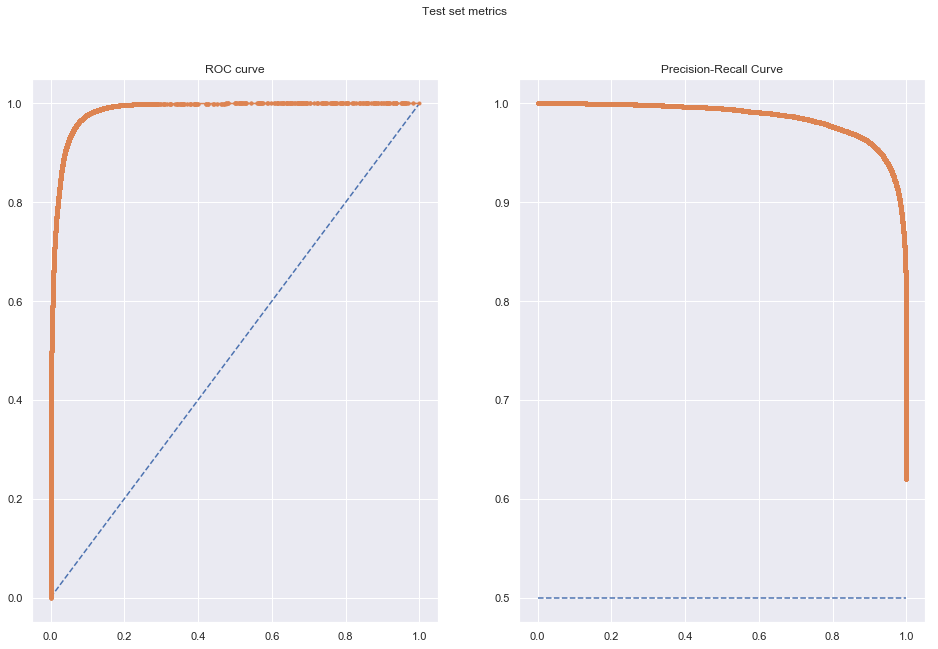

#1001, Test loss: 0.1970915
mean AUC per batch: 0.973


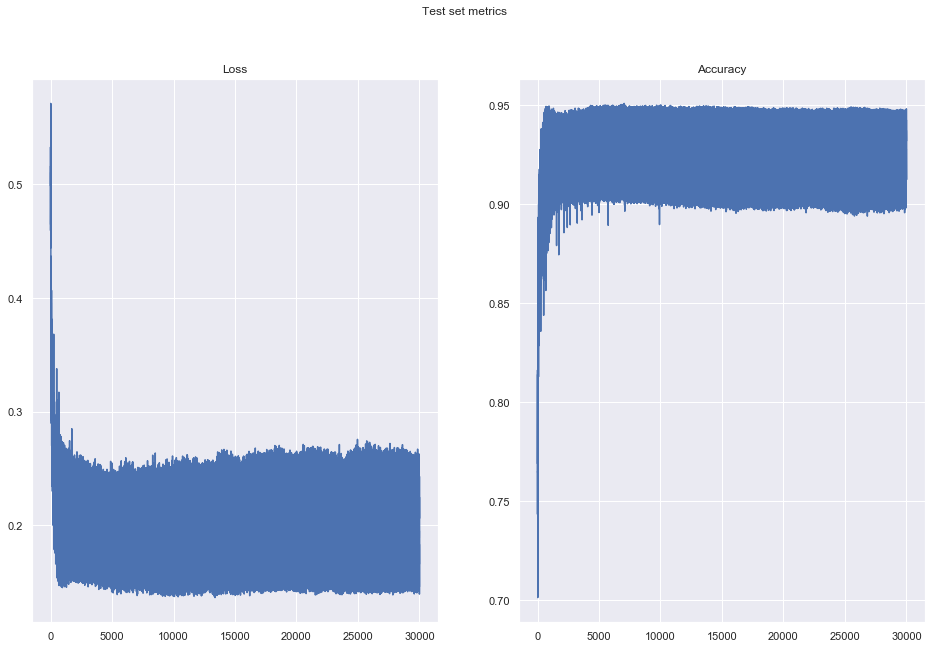

In [35]:
n_epoch = 1000

train_losses = []
test_losses = []
accs = []
aucs = []
    
for i in range(1, n_epoch + 1):      
    for shower in train_loader:

        embeddings = model(shower)

        edge_labels = (shower.y[shower.edge_index[0]] 
                       == shower.y[shower.edge_index[1]])  

        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                               embeddings[shower.edge_index[1]]], dim=1)

        edge_predicted = edge_classifier(edge_data)

        
        # calculate the batch loss
        loss = criterion(edge_predicted.view(-1), edge_labels.view(-1).float())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.detach().cpu().numpy())

    for shower in test_loader:
        
        embeddings = model(shower)


        edge_labels = (shower.y[shower.edge_index[0]] 
                           == shower.y[shower.edge_index[1]])  

        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                                   embeddings[shower.edge_index[1]]], dim=1)

        edge_predicted = edge_classifier(edge_data)

        # calculate the batch loss
        loss = criterion(edge_predicted.view(-1), edge_labels.view(-1).float())
        loss.backward()
        test_losses.append(loss.detach().cpu().numpy())

        y_true = edge_labels.view(-1).float().cpu().detach().numpy()
        y_pred = edge_predicted.view(-1).cpu().detach().numpy()


        acc = accuracy_score(y_true, y_pred.round())
        accs.append(acc)

        auc = roc_auc_score(y_true, y_pred)        
        aucs.append(auc)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)

        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

        clear_output()
        
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16,10))

        ax = axs[0]
        ax.plot([0, 1], [0, 1], linestyle='--')
        # plot the roc curve for the model
        ax.plot(fpr, tpr, marker='.')
        ax.set_title('ROC curve')

        ax = axs[1]
        ax.plot([0, 1], [0.5, 0.5], linestyle='--')
        ax.plot(recall, precision, marker='.')
        ax.set_title('Precision-Recall Curve')

        fig.suptitle('Test set metrics')
        plt.show()
   
    print("#%i, Test loss: %.7f"%(i+1,np.mean(test_losses)),flush=True)
    print('mean AUC per batch: %.3f' % np.mean(aucs))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16,10))
    
    ax = axs[0]
    ax.plot(test_losses)
    ax.set_title('Loss')

    ax = axs[1]
    ax.plot(accs)
    ax.set_title('Accuracy')

    fig.suptitle('Test set metrics')

    plt.show()

In [3]:
import pickle

In [37]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [38]:
filename = 'finalized_edge_classifier.sav'
pickle.dump(edge_classifier, open(filename, 'wb'))

## Trained model applying 

In [26]:
filename = 'finalized_model_all_new.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [28]:
filename = 'finalized_edge_classifier_all_new.sav'
loaded_edge_classifier = pickle.load(open(filename, 'rb'))

In [ ]:
i = 0

Graphx, Clusters, Roots = [],[],[]


for shower in test_loader:
    
    G = nx.DiGraph()
    
    clear_output()
    
    print(i)
        
    embeddings = loaded_model(shower)

    edge_labels = (shower.y[shower.edge_index[0]] 
                           == shower.y[shower.edge_index[1]])  

    edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                                   embeddings[shower.edge_index[1]]], dim=1)

    edge_predicted = loaded_edge_classifier(edge_data)
    
    #add predicted weight to tensor
    shower.weight = torch.tensor(edge_predicted, dtype=torch.float32)
    
    
    #Clear the edges with predicted weight < 0.45
    edge_indices = shower.edge_index.t()[(edge_predicted > 0.45).view(-1)]
    
    #Collect weights
    weights = shower.weight[(edge_predicted > 0.45).view(-1)].cpu().detach().numpy()
    
    #Clear single points
    points = np.unique(edge_indices.view(-1).cpu().detach().numpy())
    points.sort()
    
    #Check the direction of th graph
    SX = shower.pos.t()[0].cpu().detach().numpy()
    SY = shower.pos.t()[1].cpu().detach().numpy()
    SZ = shower.pos.t()[2].cpu().detach().numpy()
    TX = shower.pos.t()[3].cpu().detach().numpy()
    TY = shower.pos.t()[4].cpu().detach().numpy()
    
    
    z0 = edge_indices.t()[0]
    z1 = edge_indices.t()[1]
    
    for i in range(len(z1)):
        if SZ[z1[i]] < SZ[z0[i]]:
            print(i, 'Need to change!')
            SZ[z1[i]], SZ[z0[i]] = SZ[z0[i]], SZ[z1[i]]
    
    
    #add nodes to graph
    nodes_to_add = []
    
    for k in points:
        nodes_to_add.append(
            (
                k,
                {
                    'features': {
                        'SX': SX[k]*5000,
                        'SY': SY[k]*5000,
                        'SZ': SZ[k]*5000,
                        'TX': TX[k],
                        'TY': TY[k],
                        },
                    }
                )
            )
    
    G.add_nodes_from(nodes_to_add)
    
    #add edges to graph 
    edges_to_add = []

    for k in range(len(edge_indices)):
        p0 = edge_indices.cpu().detach().numpy()[k][0]
        p1 = edge_indices.cpu().detach().numpy()[k][1]
        weight = 1.0 - float(weights[k])
        edges_to_add.append((p0, p1, weight))



    G.add_weighted_edges_from(edges_to_add)
    
    
    i+=1
    
    graphx, clusters, roots = run_hdbscan_on_brick(G)
    
    Graphx.append(graphx)
    Clusters.append(clusters)
    Roots.append(roots)

In [41]:
from functools import total_ordering

@total_ordering
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.nodes_in = Counter()
        self.nodes_out = Counter()
        
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / (weight + 1e-5)
        
        self.weight_birth = weight
        self.lambda_birth = 1. / (weight + 1e-5)
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.nodes_in.update(cluster.nodes_in)
                self.nodes_out.update(cluster.nodes_out)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.nodes_out.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.cl_size = cl_size
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.is_cluster = len(self) >= self.cl_size
        self.is_noise = not self.is_cluster
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def __hash__(self):
        return self.__hash
    
    def __eq__(self, other):
        return self.__hash == other.__hash

    def __lt__(self, other):
        return self.__hash < other.__hash
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        
    def calculate_stability(self):
        self.stability = 0.
        self.lambda_birth = 1 / (max(self.weights_nodes_dict.keys()) + 1e-5)
        norm = self.lambda_birth
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1 / (weight + 1e-5) - self.lambda_birth) * norm
            
def calc_stabilities(root):
    root.calculate_stability()
    for child in root:
        calc_stabilities(child)
        
        
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def flat_clusters(root):
    if root.is_cluster:
        yield root
        
    for child in root:
        for cluster in flat_clusters(child):
            yield cluster
            
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)

    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples, end=' ')
    print('stability={:.3f}'.format(root.stability))
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)
        
def leaf_clusters(root):
    if root.is_cluster and len(root.children) == 0:
        yield root
        
    for child in root:
        for cluster in leaf_clusters(child):
            yield cluster

def max_level_clusters(root, level=0, max_level=2):
    if level == max_level and root.is_cluster:
        yield root
        
    for child in root:
        for cluster in max_level_clusters(child, level=level+1, max_level=max_level):
            yield cluster
            
            
def recalc_tree(root):
    weights_children = 0
    for child in root:
        weights_children += recalc_tree(child)
    if weights_children > root.stability:
        root.stability = weights_children
    else:
        root.children.clear()
    
    return root.stability

In [42]:
import operator
from collections import Counter

def run_hdbscan(G, cl_size=20, order=True):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    edges = []
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        edges.append(
            (
            node_id_left, node_id_right, edge['weight'], np.sign(node_left['features']['SZ'] - node_right['features']['SZ'])
            )
        )

    #nx.mini
    #edges = list(G.edges(data=True))
    #edges = [(edge[0], # 0
    #          edge[1], # 1
    #          edge[2]['weight'], # 2
    #         ) for edge in edges]
    
    edges = sorted(edges, key = operator.itemgetter(2))

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications

    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    
    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, *_ in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        #if cluster_in.nodes_in[j] > 1:
        #    continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    #recalc_tree(root)
    clusters = list(leaf_clusters(root))
    return clusters, root

In [ ]:
def run_hdbscan_on_brick(graphx, min_cl=25, cl_size=25, order=True):
    connected_components = []
    for cnn in nx.connected_components(nx.Graph(graphx)):
        if len(cnn) > min_cl:
            connected_components.append(nx.DiGraph(graphx.subgraph(cnn)))
    clusters = []
    roots = []
    for G in connected_components:
        if len(G) < 100:
            clusters.append(G)
        else:
            clusters_hdbscan, root_hdbscan = run_hdbscan(G, cl_size=cl_size, order=order)
            roots.append(root_hdbscan)
            clusters.extend(clusters_hdbscan)
    
    return graphx, clusters, roots

In [54]:
for i in range(len(Clusters)):
    print(i, len(Clusters[i]))

0 84
1 63
2 45
3 42
4 45
5 36
6 48
7 46
8 17
9 44
10 43
11 65
12 64
13 34
14 30
15 45
16 28
17 41
18 11
19 55
20 31
21 50
22 65
23 17
24 45
25 41
26 34
27 43
28 46
29 61


In [47]:
len(Roots)

30

In [48]:
Graphx[0]